In [188]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os
from helper import train_VAE 
from VAE_model import VAE
import json
X_train = pd.read_csv('../../../datasets/Bikerental/X_train.csv',index_col=0)  
X_test = pd.read_csv('../../../datasets/Bikerental/X_test.csv',index_col=0)  
y_train = pd.read_csv('../../../datasets/Bikerental/y_train.csv',index_col=0)  
y_test = pd.read_csv('../../../datasets/Bikerental/y_test.csv',index_col=0) 
X_train_with_confounder=X_train.drop(columns=['season_SPRING','season_FALL','season_SUMMER','season_WINTER'])
X_test_with_confounder=X_test.drop(columns=['season_SPRING','season_FALL','season_SUMMER','season_WINTER'])
print(X_train.shape)
print(X_train_with_confounder)
print(X_test.shape)
print(X_test_with_confounder.shape)
print(X_train.columns)
print(X_train_with_confounder.columns)
X_train_with_confounder
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_with_confounder)
X_test_scaled = scaler.transform(X_test_with_confounder)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.dpi']=200

def custom_scale(data, min_val=0, max_val=10000):
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

# Apply custom scaling to y_train and y_test
y_train_scaled = custom_scale(y_train)
y_test_scaled = custom_scale(y_test)
np.random.seed(1337)

(584, 14)
       yr       temp      hum  windspeed  days_since_2011  holiday_HOLIDAY  \
59   2011   4.533349  53.5000  14.500475               59                0   
700  2012   6.021651  80.6667   4.000181              700                0   
662  2012  19.612500  63.6250   4.876206              662                0   
688  2012   9.899151  62.3333  15.749489              688                0   
222  2011  25.722500  42.3750  11.041332              222                0   
..    ...        ...      ...        ...              ...              ...   
422  2012   9.233349  49.0833  17.958211              422                0   
95   2011  10.369151  47.0833  17.625221               95                0   
294  2011  11.857500  62.9167   6.208669              294                0   
202  2011  31.871651  58.0417   8.917700              202                0   
605  2012  26.231651  62.0000  12.791975              605                0   

     workingday_WORKING DAY  weathersit_GOOD  weather

In [14]:
load_model="Bike__freeze_z_and_zz_to_y_R2_0_8498606589382115"

In [15]:
with open(f'Config_{load_model}.json') as country_json1:
          config = json.load(country_json1)
          print(config)

{'config': {'x_dim': 10, 'z_dim': 4, 'zz_dim': 1, 'encoder_z_layers': [128, 128], 'encoder_zz_layers': [5, 5, 5], 'decoder_layers': [128, 128, 10], 'fc_z_to_y_layers': [28, 28, 1]}, 'beta': {'b1': 10000, 'b2': 1, 'b3': 1, 'b4': 1000, 'b5': 1}, 'lr': 0.001, 'batch_size': 32, 'num_epochs': 700}


In [16]:
config_params = config['config']
beta = config['beta']
lr = config['lr']
batch_size = config['batch_size']
num_epochs = config['num_epochs']

x_dim = config_params['x_dim']
z_dim = config_params['z_dim']
zz_dim = config_params['zz_dim']
encoder_z_layers = config_params['encoder_z_layers']
encoder_zz_layers = config_params['encoder_zz_layers']
decoder_layers = config_params['decoder_layers']
fc_z_to_y_layers = config_params['fc_z_to_y_layers']
b1 = beta['b1']
b2 = beta['b2']
b3 = beta['b3']
b4 = beta['b4']
b5 = beta['b5']
model=VAE(x_dim, z_dim, zz_dim, encoder_z_layers, encoder_zz_layers, decoder_layers, fc_z_to_y_layers,z_and_zz_to_y=False)

In [79]:
train_ds = TensorDataset(torch.Tensor(X_train_scaled), torch.Tensor(y_train.to_numpy()))

test_ds = TensorDataset(torch.Tensor(X_test_scaled), torch.Tensor(y_test.to_numpy()))

In [80]:
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)

test_loader = DataLoader(test_ds, batch_size=config["batch_size"])

In [22]:
model = torch.load(f"./{load_model}_model.zip",)
model.to(device)
model.eval()

VAE(
  (encoder_z_seq): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (fc21): Linear(in_features=128, out_features=4, bias=True)
  (fc22): Linear(in_features=128, out_features=4, bias=True)
  (encoder_zz_seq): Sequential(
    (0): Linear(in_features=4, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
  )
  (fcz21): Linear(in_features=5, out_features=1, bias=True)
  (fcz22): Linear(in_features=5, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (zz_to_y): Sequential(
    (0): Linear(in_features=5, out_f

In [144]:
class masked_model():
    def __init__(self, model,scaling):
        self.model = model
        self.scaling=scaling
    
    def forward(self,x):
        _,_,_,_,_,prediction=model(x)
        return prediction*self.scaling

In [145]:
mod=masked_model(model,10000)

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def ice_plot_VAE(model, X_s, X, y,feature,o_i,title, num_points=None,loc="best",num_of_rounds=5,size=None):
    """
    Function to calculate and plot Individual Conditional Expectation (ICE) plot for the specified feature.
    
    Args:
    model (nn.Module): Trained PyTorch model.
    X_s (np.ndarray): Scaled test set features.
    X (pd.DataFrame): Unscaled test set features.
    y (pd.Series): Test set target values.
    feature_index (int): Index of the feature for which ICE plot is to be calculated.
    feature_names (list): List of feature names.
    feature (str): Name of the feature for which ICE plot is to be calculated.
    num_points (int, optional): Number of points to use for generating ICE plot. Default is None (use all unique values).
    """
    feature_names=X.columns
    feature_index=feature_names.get_loc(feature)
  
    if size is not None:
        if size>len(X):
            print("Not enough Data, size > len(X)")
        indices = np.random.choice(len(X_s), size, replace=False,)
    
            # Extract samples using the indices
        X_s = X_s[indices]
        X = X.iloc[indices]
            

    # Extract the unique feature values from the unscaled data
    feature_values = pd.unique(X.loc[:, feature].sort_values())
    feature_values_s = np.unique(np.sort(X_s[:, feature_index]))
    

    # If num_points is specified, select a subset of equally spaced unique feature values
    if num_points is not None:
        idx = np.round(np.linspace(0, len(feature_values) - 1, num_points)).astype(int)
        feature_values = feature_values[idx]
        feature_values_s = feature_values_s[idx]

    # Initialize a figure
    plt.figure()
    
    XXX = X_s.copy()
    predictions_all = []
    # Define season colors
    season_colors = {'FALL': 'orange', 'SPRING': 'green', 'SUMMER': 'red', 'WINTER': 'blue',}

    
    # Loop through instances in the test set
    for instance,i in zip(XXX,X.values):
        # Create an array to store predictions for this instance
        predictions = []
        mean_ori=0
        for _ in range(num_of_rounds):
            original_prediction = model(torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)).item()
            mean_ori+=original_prediction
        mean_ori=mean_ori/num_of_rounds

        # Loop through the unique feature values
        for val in feature_values_s:
            # Set the feature value for the current instance
            instance[feature_index] = val


            # Convert the instance to a PyTorch tensor and unsqueeze to add batch dimension
            instance_tensor = torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)

            # Get the prediction from the model
            with torch.no_grad():
                mean_pred=0
                for _ in range(num_of_rounds):
                    prediction = model(instance_tensor).item()
                    mean_pred+=prediction
                mean_pred=mean_pred/num_of_rounds
            predictions.append(mean_pred)

        predictions_all.append(predictions)
        # Get the season for the current instance
        season = get_season(i, feature_names)
        
        # Plot the ICE curve for this instance in grey with transparency
        plt.plot(feature_values, predictions, color=season_colors.get(season, 'grey'), alpha=0.5)
        
          # Plot the marker for the original value
        original_val = i[o_i]
        plt.scatter(original_val, mean_ori, marker='o', color=season_colors.get(season, 'grey'), zorder=10)

    # Calculate the mean of all ICE lines
    mean_predictions = np.mean(predictions_all, axis=0)
    print(len(predictions_all))

    # Plot the mean ICE curve in red and thicker
    plt.plot(feature_values, mean_predictions, color='black', linewidth=4)

    # Label the plot
    plt.xlabel(feature_names[o_i])
    plt.ylabel('Predictions')
    plt.title(title)
    
     # Create proxy artists for legend
    legend_elements = [Line2D([0], [0], color=season_colors[season], lw=2, label=season) for season in season_colors]

    # Add the legend with the proxy artists
    plt.legend(handles=legend_elements, title='Seasons', loc=loc)

    # Show the plot
    plt.show()


In [119]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def get_season(instance, feature_names):
    season_prefix = 'season_'
    for name in feature_names:
        if name.startswith(season_prefix) and instance[feature_names.get_loc(name)] == 1:
             return name[len(season_prefix):]
    return 'UNKNOWN'

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
def plot_prediction_vs_truth(model, X_s, X, y, num_points=None):
    """
    Function to calculate and plot prediction vs truth plot for the specified model.
    
    Args:
    model (nn.Module): Trained PyTorch model.
    X_s (np.ndarray): Scaled test set features.
    X (pd.DataFrame): Unscaled test set features.
    y (pd.Series): Test set target values.
    feature_names (list): List of feature names.
    num_points (int, optional): Number of points to use for generating plot. Default is None (use all points).
    """
    
    #device = next(model.parameters()).device
    feature_names=X.columns
    # Initialize a figure
    fig, ax = plt.subplots()

    # Define season colors
    season_colors = {'FALL': 'orange', 'WINTER': 'blue', 'SPRING': 'green', 'SUMMER': 'red'}

    # Find the index of the 'temp' feature
    temp_index = feature_names.get_loc('temp')
    # Get the temperature values and normalize them to range [0, 1]
    tempo_values = X.loc[:, 'temp'].values
    normalized_tempo = (tempo_values - np.min(tempo_values)) / (np.max(tempo_values) - np.min(tempo_values))

    # Generate predictions using the model
    with torch.no_grad():
        predictions = model.forward(torch.tensor(X_s, dtype=torch.float, device=device)).cpu().numpy()

    # Draw each point, colored by season and brightness by temp
    for i in range(len(X_s)):
        season = get_season(X.iloc[i, :], feature_names)
        color = sns.light_palette(season_colors.get(season, 'grey'), as_cmap=True)(normalized_tempo[i])
        plt.scatter(y[i], predictions[i], color=color, alpha=0.5)

    # Add a 45-degree line for reference
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)

    # Add labels
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    
    # Add legends for seasons
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=season_colors[season], markersize=10) 
                       for season in season_colors]
    ax.legend(legend_elements, season_colors.keys(), title="Seasons")
    
    # Add colorbar for temperature
    sm = ScalarMappable(cmap=sns.light_palette("grey", as_cmap=True), norm=plt.Normalize(0,max(tempo_values)))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='vertical', label='Temperature')
    

    plt.show()

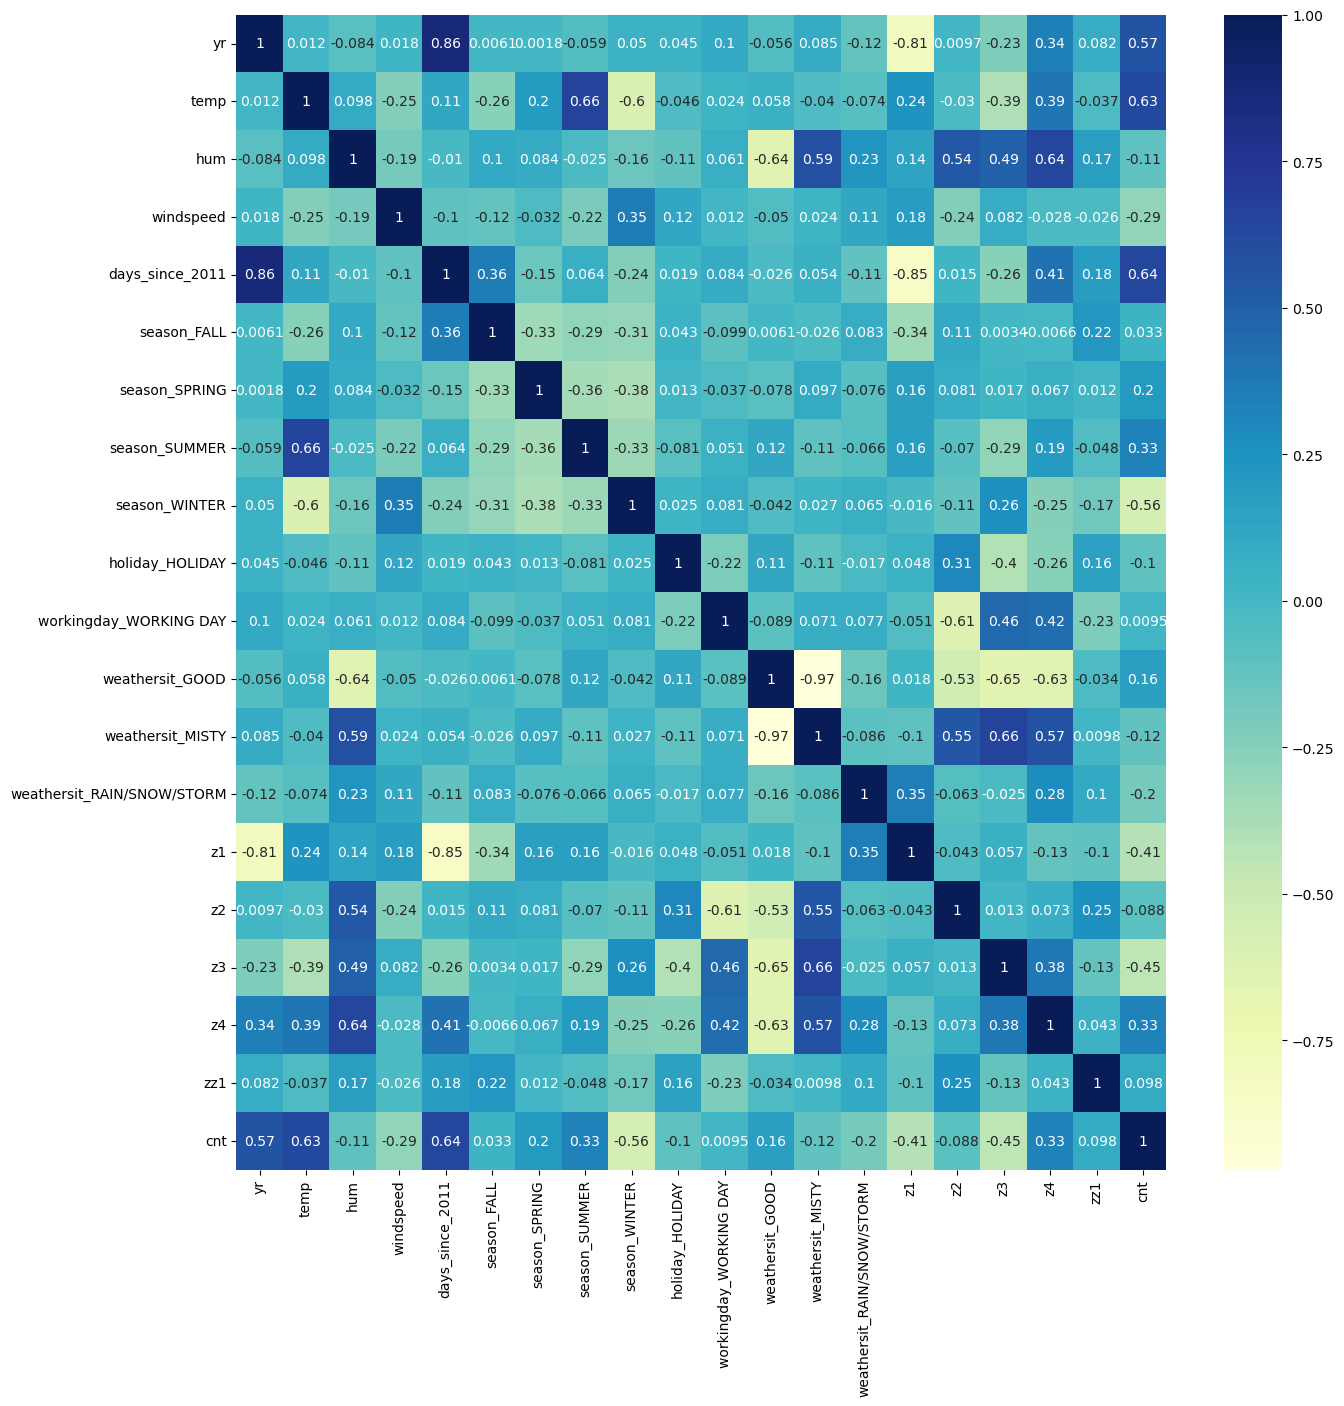

In [120]:
recon_x_subset, mu_z, log_z, mu_zz, log_zz,_ = model(torch.from_numpy(X_test_scaled).float().to(device))
# Reparameterize to get the estimated z values
z_est_subset = model.reparameterize(mu_z, log_z,1)
zz_est_subset = model.reparameterize(mu_zz, log_zz,1)


z_columns = [f'z{i+1}' for i in range(z_dim)]
zz_columns = [f'zz{i+1}' for i in range(zz_dim)]

# Convert your tensor to a dataframe
zz_est_df = pd.DataFrame(zz_est_subset.cpu().detach().numpy(), columns=zz_columns)
z_est_df = pd.DataFrame(z_est_subset.cpu().detach().numpy(), columns=z_columns)
# Reset the index of both dataframes
X_test_reset = pd.DataFrame(X_test).reset_index(drop=True)
z_est_df_reset = z_est_df.reset_index(drop=True)
zz_est_df = zz_est_df.reset_index(drop=True)
y_test_reset=  pd.DataFrame(y_test).reset_index(drop=True)


# Concatenate the dataframes
df = pd.concat([X_test_reset, z_est_df_reset,zz_est_df,y_test_reset], axis=1)

plt.figure(figsize=(15, 15))
# Compute the correlation matrix
corr = df.corr()

# Generate a heatmap
sns.heatmap(corr, cmap="YlGnBu",annot=True)
# Save the figure
#pic_name_heat = create_picture_name(config, "heatmap")
#print(pic_name_heat)
#plt.savefig(os.path.join(path, pic_name_heat))
plt.show()

In [121]:
feature_names = ['yr', 'temp', 'hum', 'windspeed', 'days_since_2011', 'season_FALL',
                 'season_SPRING', 'season_SUMMER', 'season_WINTER', 'holiday_HOLIDAY',
                 'workingday_WORKING DAY', 'weathersit_GOOD', 'weathersit_MISTY',
                 'weathersit_RAIN/SNOW/STORM']

In [122]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
criterion = RMSELoss()

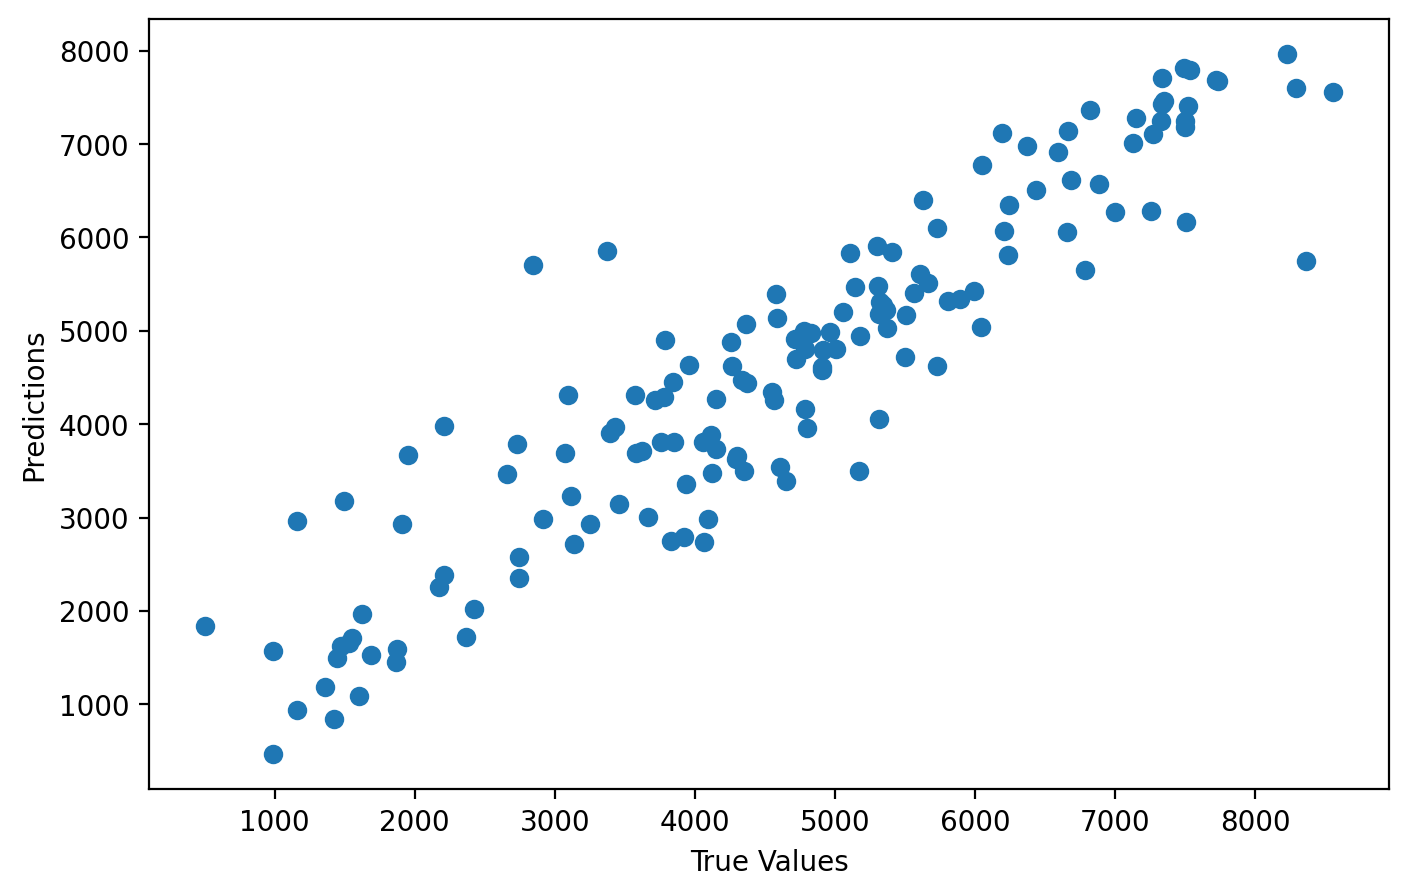

R^2 score: 0.8458678650687957
Train_loss: 492.1852325439453
Test_loss: 742.2852844238281


In [156]:
def plot_predictions_VAE(net, data_loader, device):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = net(inputs)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    plt.scatter(y_true, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    ss_tot = np.sum((y_true - y_bar) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2
plot_predictions_VAE(mod.forward, test_loader, device)
y_true = np.array(y_test,dtype=object)

r2_Scores=0
for _ in range(10):
    y_pred = mod.forward(torch.Tensor(X_test_scaled).to(device))
    y_pred=y_pred.cpu().detach().numpy()
    r2 = r2_score(y_test, y_pred)
    r2_Scores+=r2
print("R^2 score:", r2_Scores/10)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)
trls=0
tels=0
for _ in range(10):
    trls+=criterion(mod.forward(torch.Tensor(X_train_scaled).to(device)),y_train_tensor).item()
    tels+=criterion(mod.forward(torch.Tensor(X_test_scaled).to(device)),y_test_tensor).item()
    

print("Train_loss:",trls/10)
print("Test_loss:",tels/10)


In [157]:
plot_prediction_vs_truth(mod, X_test_scaled, X_test, y_test.to_numpy())

In [193]:

ice_plot_VAE(mod.forward, X_test_scaled,X_test, y_test,'temp',1,"ICE plot for the variable tempreture",num_of_rounds=20,size=30)

30


In [195]:
ice_plot_VAE(mod.forward, X_test_scaled,X_test, y_test,'temp',1,"ICE plot for the variable tempreture",num_of_rounds=20)

147


30


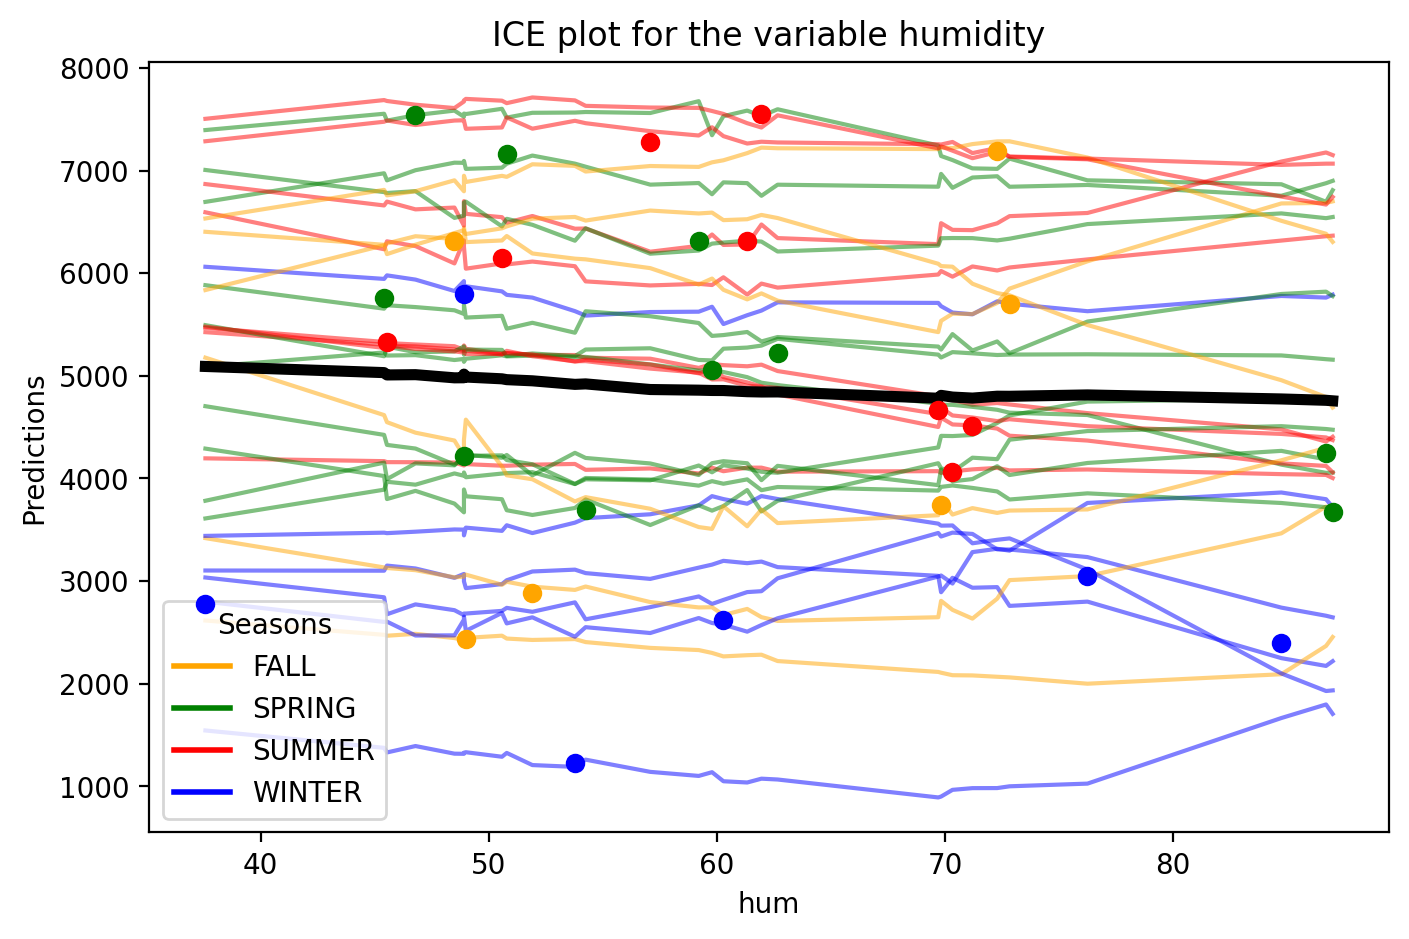

In [196]:
ice_plot_VAE(mod.forward, X_test_scaled,X_test, y_test,'hum',2,"ICE plot for the variable humidity",num_of_rounds=20,size=30)

147


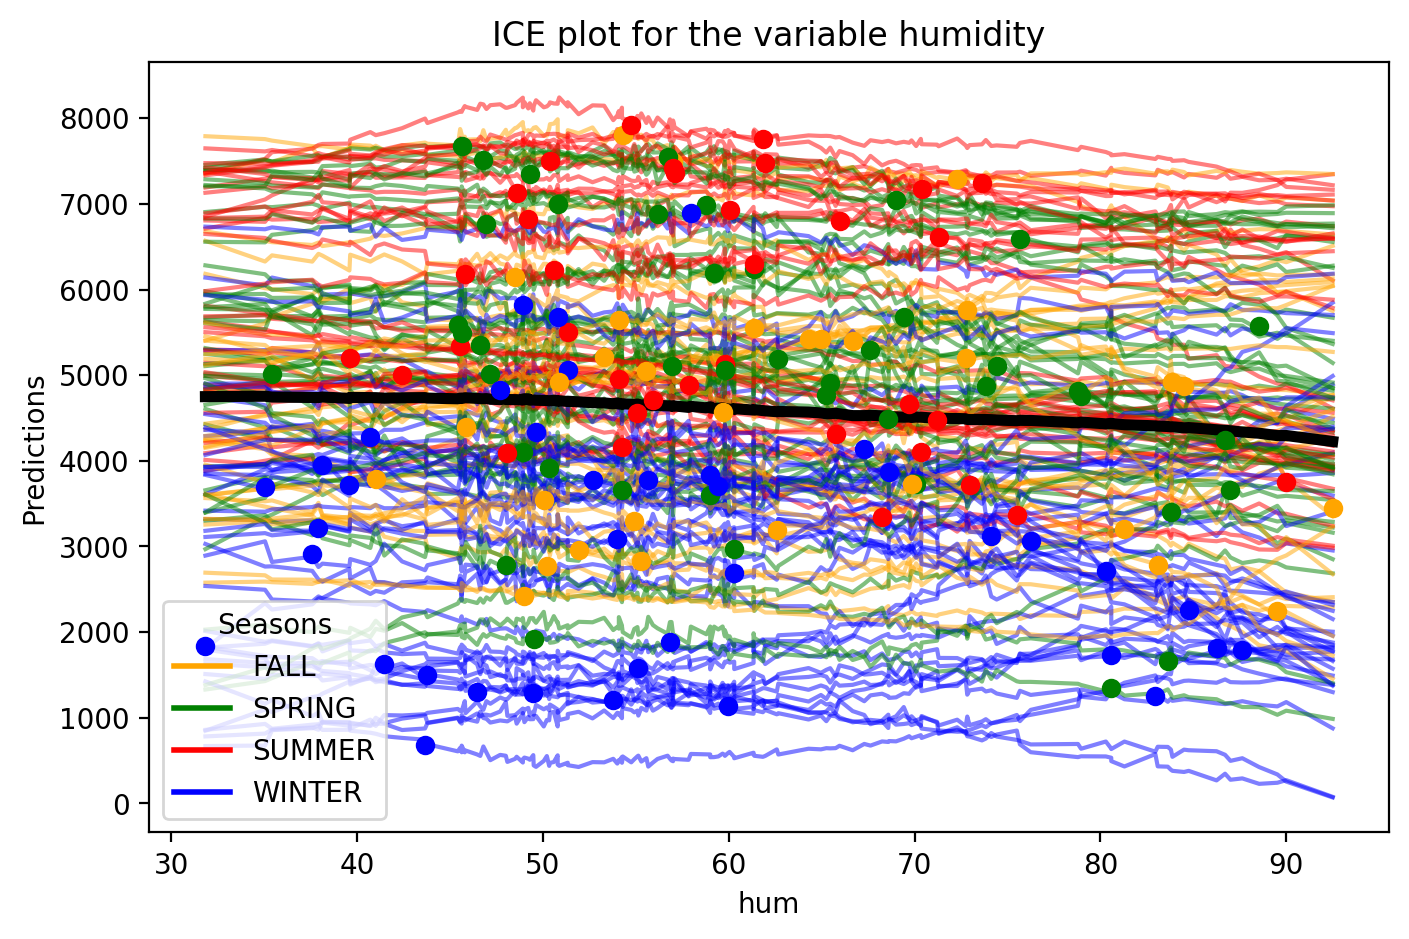

In [197]:
ice_plot_VAE(mod.forward, X_test_scaled,X_test, y_test,'hum',2,"ICE plot for the variable humidity",num_of_rounds=20)

30


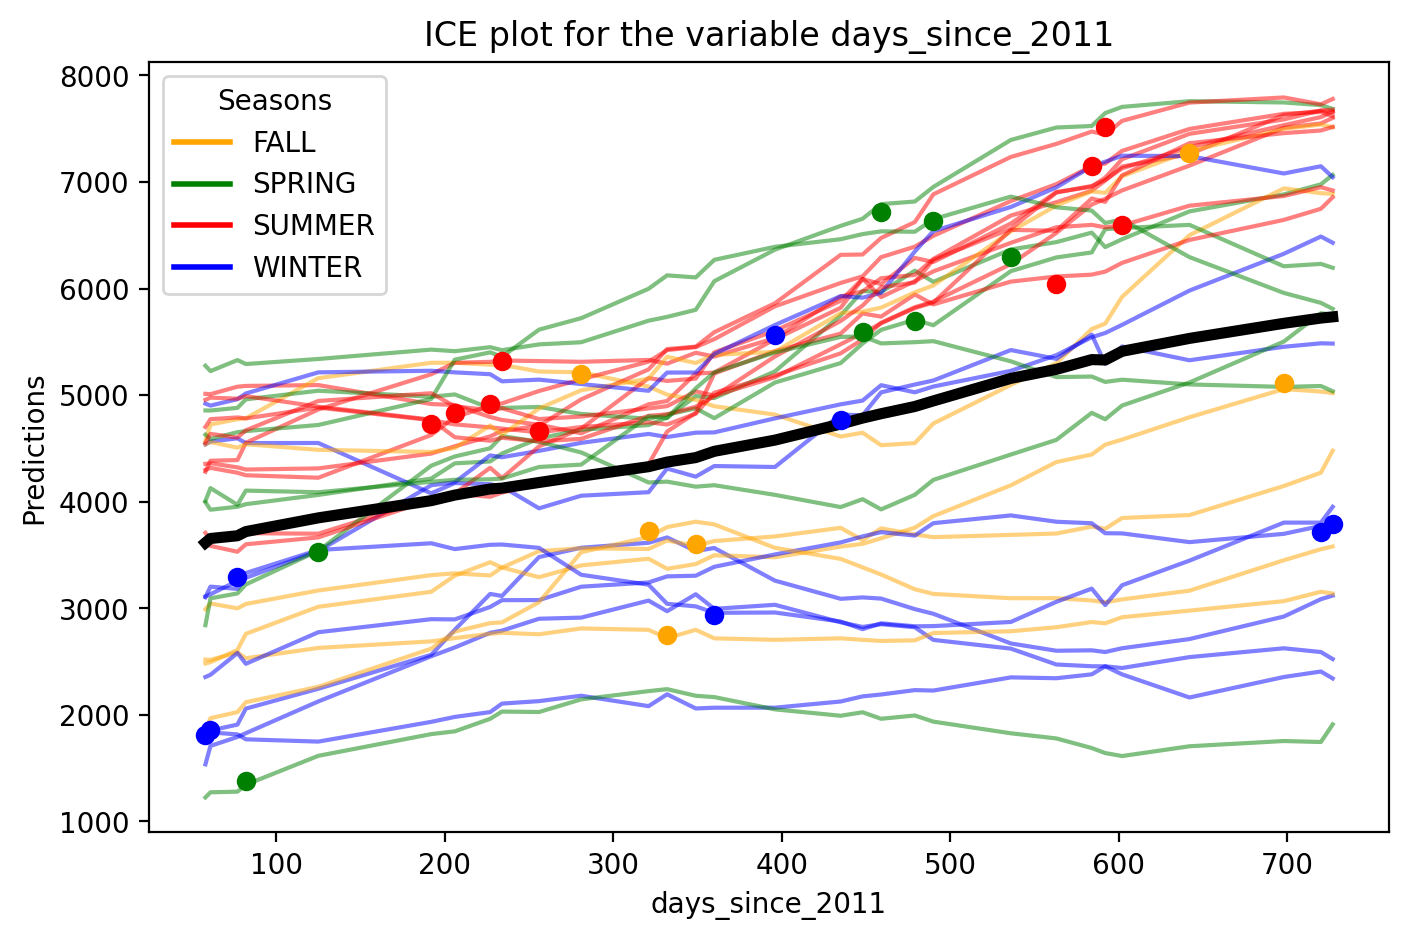

147


In [198]:
ice_plot_VAE(mod.forward, X_test_scaled,X_test, y_test,'days_since_2011',4,"ICE plot for the variable days_since_2011",num_of_rounds=20,size=30)
ice_plot_VAE(mod.forward, X_test_scaled,X_test, y_test,'days_since_2011',4,"ICE plot for the variable days_since_2011",num_of_rounds=20)

In [199]:
ice_plot_VAE(mod.forward, X_test_scaled,X_test, y_test,'windspeed',3,"ICE plot for the variable windspeed",num_of_rounds=20,size=30)
ice_plot_VAE(mod.forward, X_test_scaled,X_test, y_test,'windspeed',3,"ICE plot for the variable windspeed",num_of_rounds=20)

30


147


In [206]:
ice_plot_VAE(mod.forward, X_test_scaled,X_test, y_test,'yr',0,"ICE plot for the variable year",num_of_rounds=20,size=30)
ice_plot_VAE(mod.forward, X_test_scaled,X_test, y_test,'yr',0,"ICE plot for the variable year",num_of_rounds=20)

30


147


In [201]:
from captum.attr import KernelShap

In [222]:
baseline_unscaled = X_test_with_confounder.mean(axis=0)

In [223]:
baseline_unscaled

yr                            2011.510204
temp                            15.322261
hum                             60.256324
windspeed                       13.208245
days_since_2011                361.142857
holiday_HOLIDAY                  0.020408
workingday_WORKING DAY           0.700680
weathersit_GOOD                  0.639456
weathersit_MISTY                 0.346939
weathersit_RAIN/SNOW/STORM       0.013605
dtype: float64

In [272]:
y_test_series = y_test.iloc[:, 0]
X_test_scaled[y_test_series.argmin()]
worst_instance = torch.tensor(X_test_scaled[y_test_series.argmin()]).unsqueeze(0).float().to(device)
best_instance = torch.tensor(X_test_scaled[y_test_series.argmax()]).unsqueeze(0).float().to(device)
#median_instance = torch.tensor(X_test_scaled[median_index]).unsqueeze(0).float().to(device)

baseline = torch.tensor(X_test_scaled.mean(axis=0)).unsqueeze(0).float().to(device)
avg_worst=0
avg_best=0
avg_base=0
for _ in range(num_runs):
    avg_worst+=mod.forward(worst_instance)
    avg_best+=mod.forward(best_instance)
    avg_base+=mod.forward(baseline)
avg_worst=avg_worst/num_runs
avg_best=avg_best/num_runs
avg_base=avg_base/num_runs
print(avg_worst)
print(avg_best)
print(avg_base)

tensor([[1765.7521]], grad_fn=<DivBackward0>)
tensor([[7836.9668]], grad_fn=<DivBackward0>)
tensor([[4787.0127]], grad_fn=<DivBackward0>)


In [273]:
# Instantiate KernelShap
ks = KernelShap(mod.forward)

In [280]:
num_runs = 100

# Initialize accumulators to zero
cumulative_worst_shap_values = 0
cumulative_best_shap_values = 0
cumulative_baseline_shap_values = 0

for _ in range(num_runs):
    cumulative_worst_shap_values += ks.attribute(worst_instance, baseline, n_samples=200)
    cumulative_best_shap_values += ks.attribute(best_instance, baseline, n_samples=200)
    #cumulative_baseline_shap_values += ks.attribute(baseline, baseline, n_samples=30000)

# Calculate the average by dividing by the number of runs
average_worst_shap_values = cumulative_worst_shap_values / num_runs
average_best_shap_values = cumulative_best_shap_values / num_runs
#average_baseline_shap_values = cumulative_baseline_shap_values / num_runs


In [281]:
average_worst_shap_values = average_worst_shap_values.cpu().detach().numpy()
average_best_shap_values = average_best_shap_values.cpu().detach().numpy()

In [282]:
import shap
def shap_vis(values,baseline_shap_values,data,feature_names):
    print(values)
    print(baseline_shap_values)
    print(data)

    # define the corresponding SHAP values
    shap_values = values

    # get the index of the baseline value
    baseline_index = np.argmin(np.abs(shap_values))

    # get the baseline value
    baseline_value = baseline_shap_values

    # create a SHAP Explanation object
    expl = shap.Explanation(values=shap_values,
                        base_values=baseline_value,
                        data=data,
                        feature_names=feature_names)

    # create a SHAP waterfall plot
    shap.plots.waterfall(expl)

    shap.plots.force(expl)

[ 410.945     353.4583    187.42499   -38.560192 1587.1566     32.518417
 -401.20175   127.43584   842.1742    -53.334824]
4787.0126953125
yr                            2012.000000
temp                            17.497500
hum                             54.291700
windspeed                       15.249468
days_since_2011                637.000000
holiday_HOLIDAY                  0.000000
workingday_WORKING DAY           0.000000
weathersit_GOOD                  1.000000
weathersit_MISTY                 0.000000
weathersit_RAIN/SNOW/STORM       0.000000
Name: 637, dtype: float64


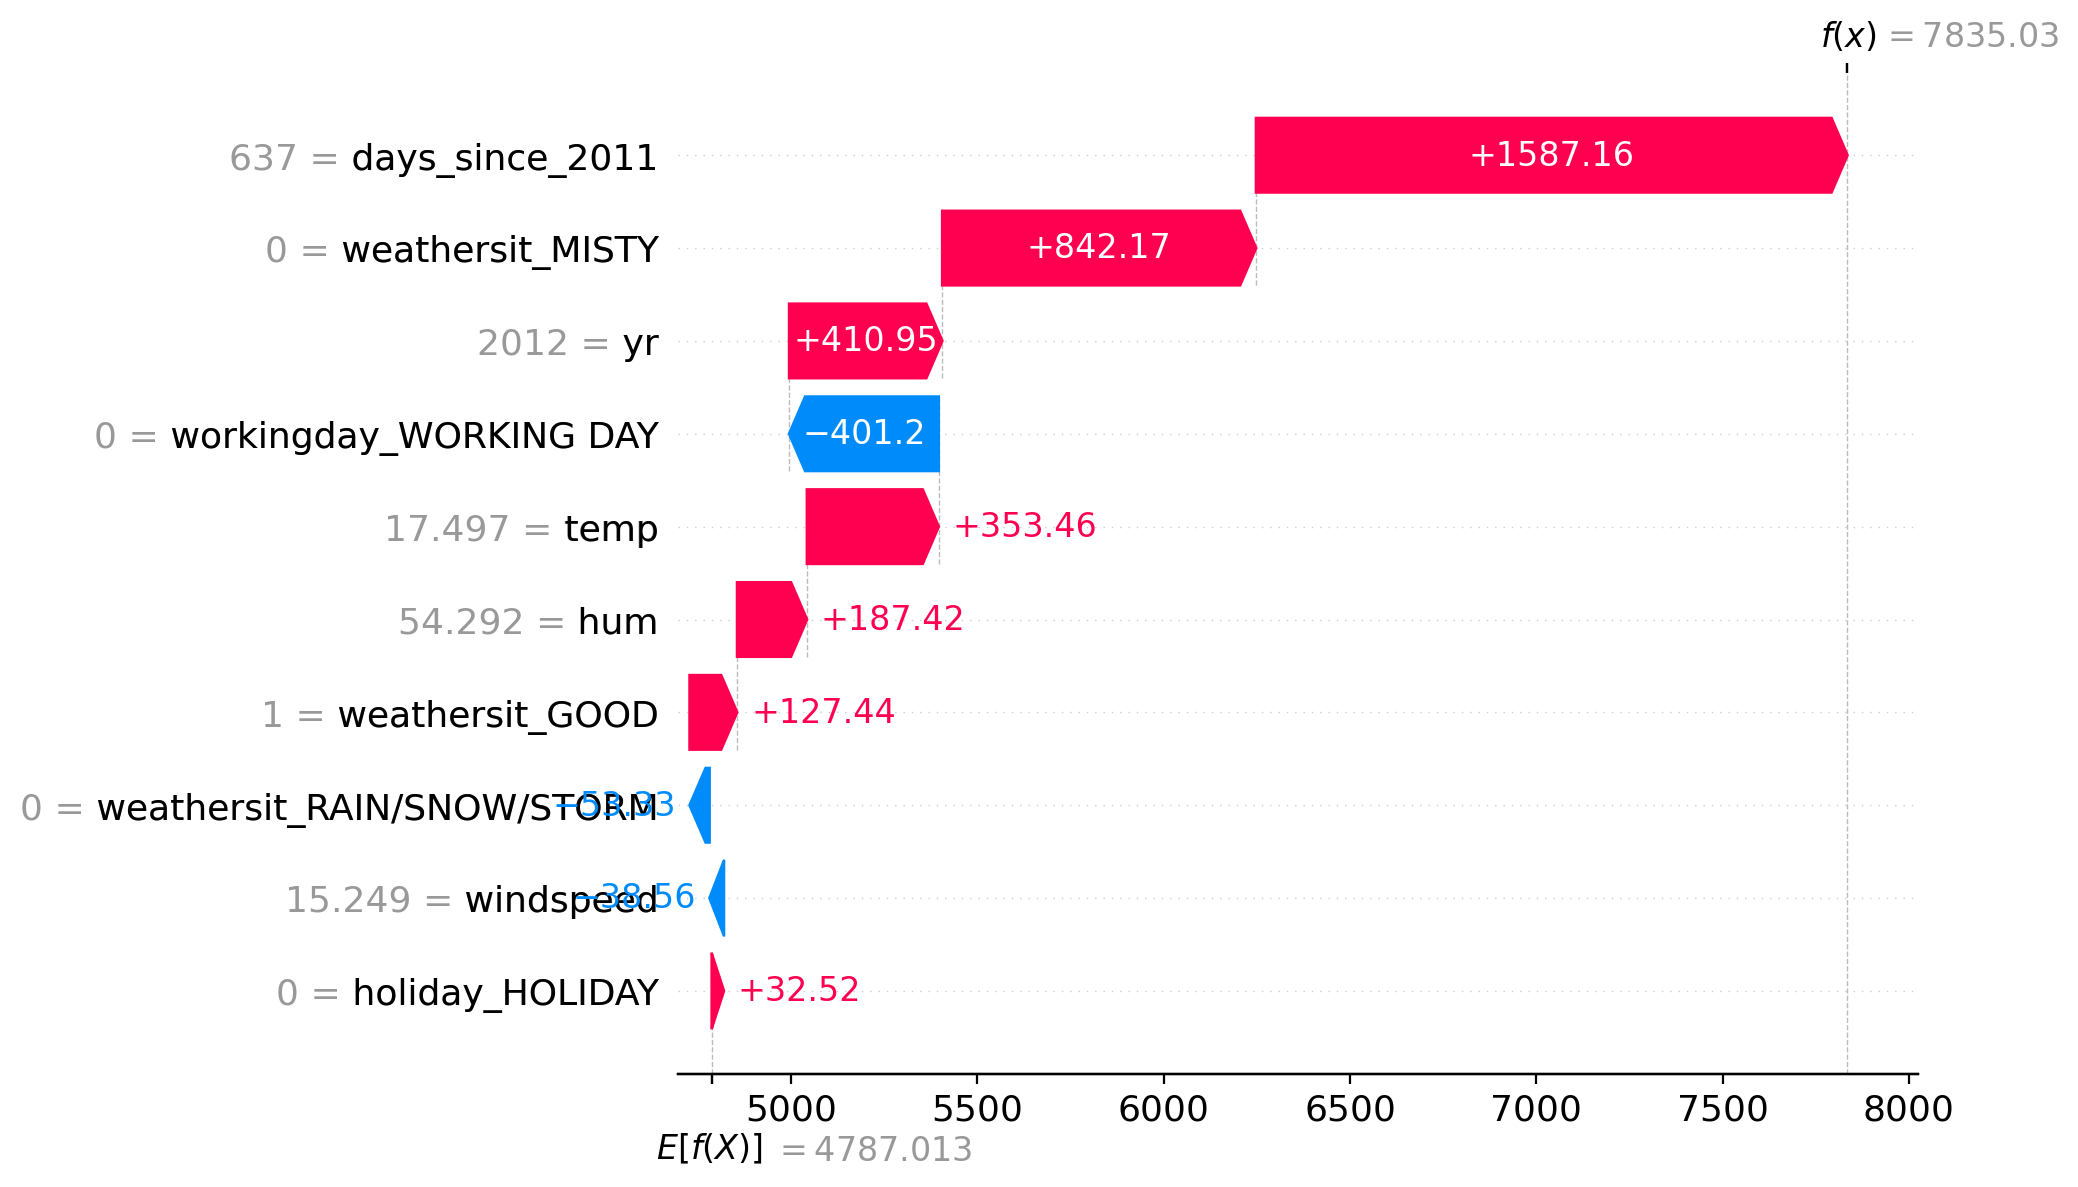

In [283]:
shap_vis(average_best_shap_values[0],avg_base.item(),X_test_with_confounder.iloc[y_test_series.argmax()],X_test_with_confounder.columns)

[ -174.07426   -801.35657     31.40759     33.75621   -568.5585
   -27.358814  -150.55756    -15.948639   100.35882  -1442.7585  ]
4787.0126953125
yr                            2011.00000
temp                             2.22250
hum                             86.25000
windspeed                       19.68795
days_since_2011                 25.00000
holiday_HOLIDAY                  0.00000
workingday_WORKING DAY           1.00000
weathersit_GOOD                  0.00000
weathersit_MISTY                 0.00000
weathersit_RAIN/SNOW/STORM       1.00000
Name: 25, dtype: float64


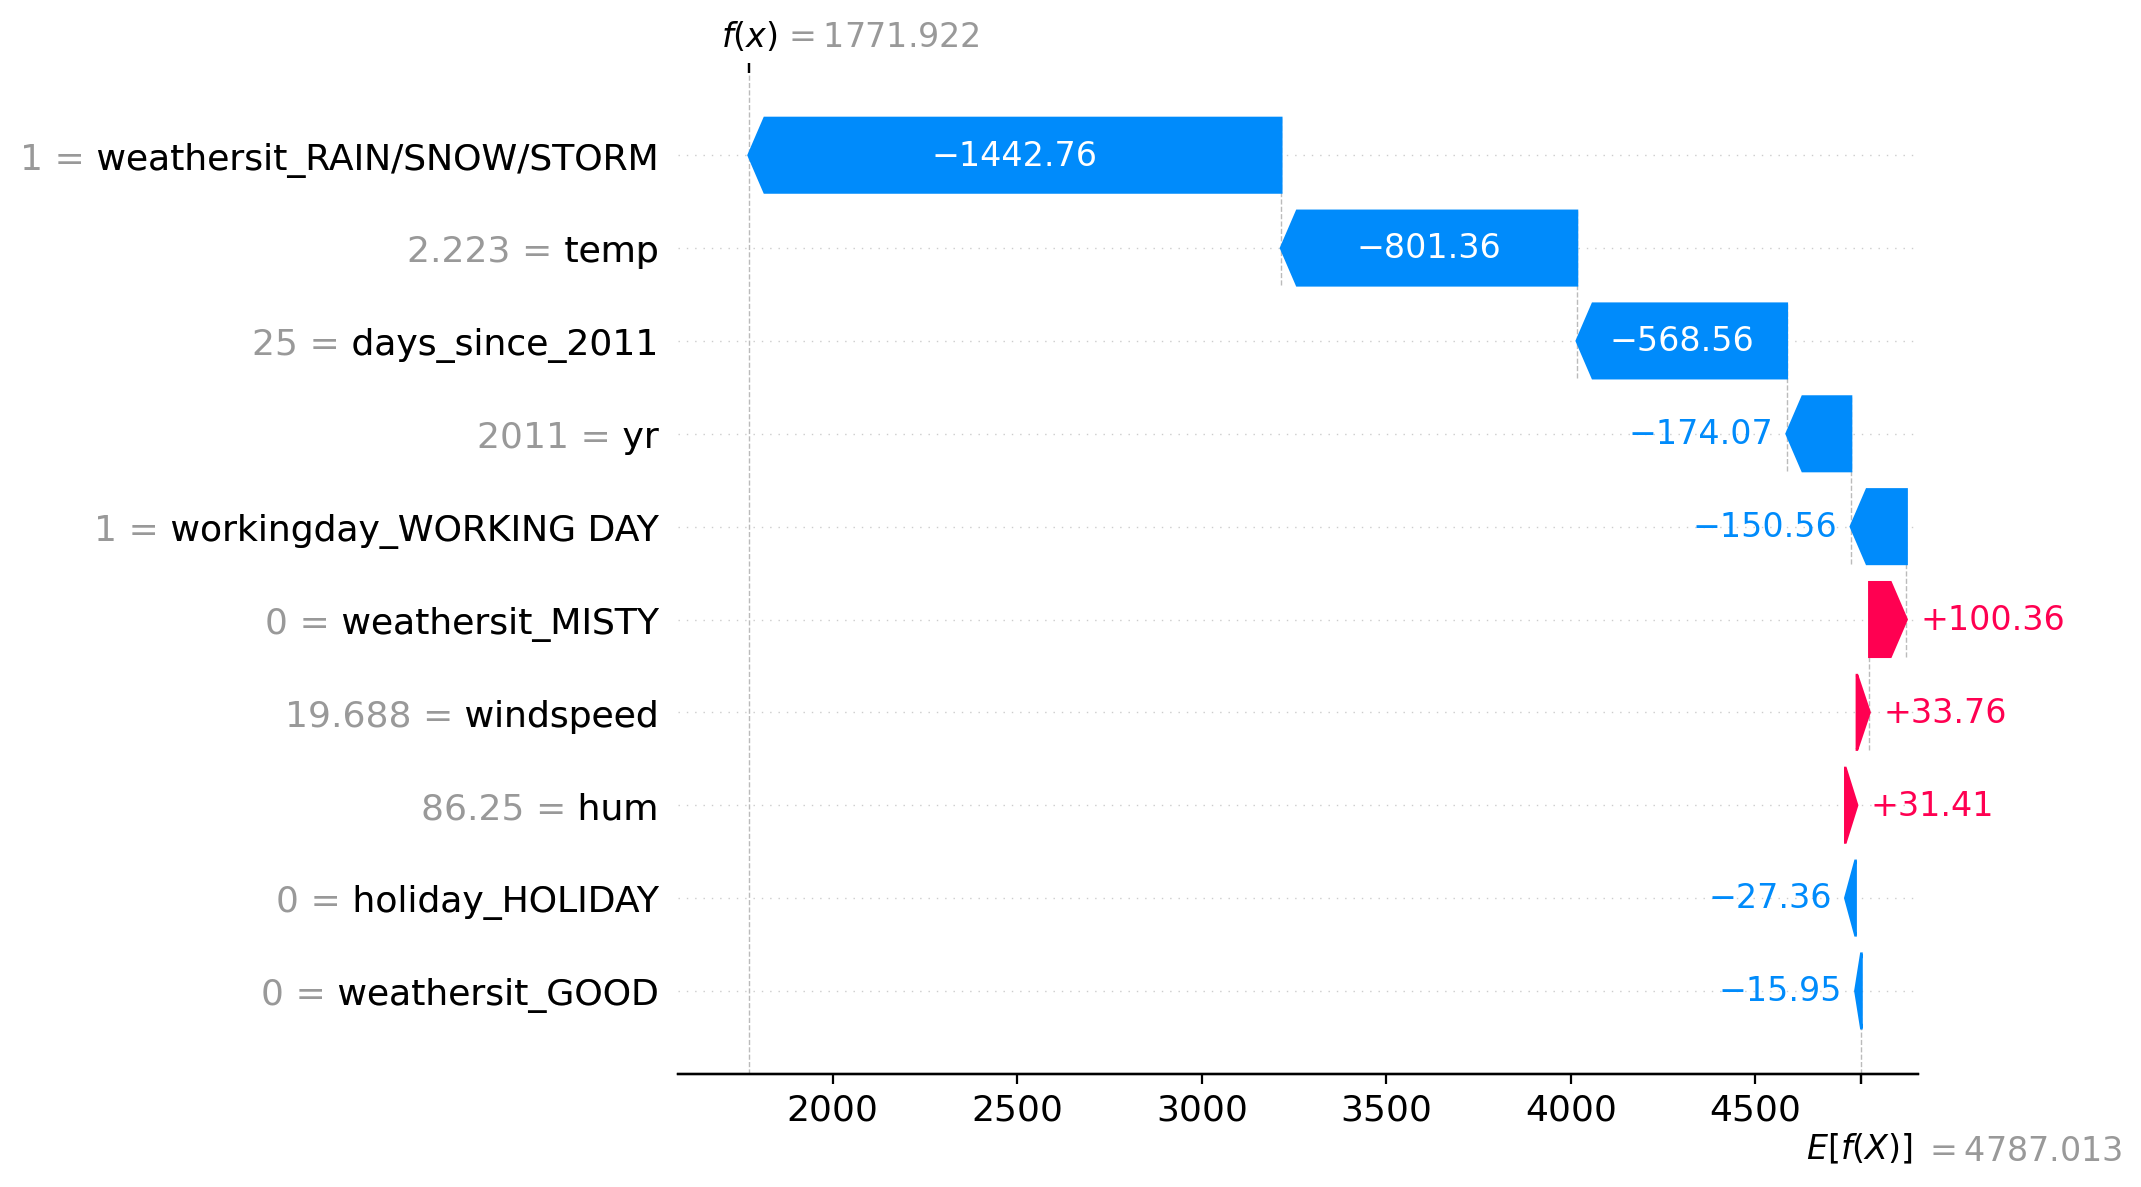

In [285]:
shap_vis(average_worst_shap_values[0],avg_base.item(),X_test_with_confounder.iloc[y_test_series.argmin()],X_test_with_confounder.columns)

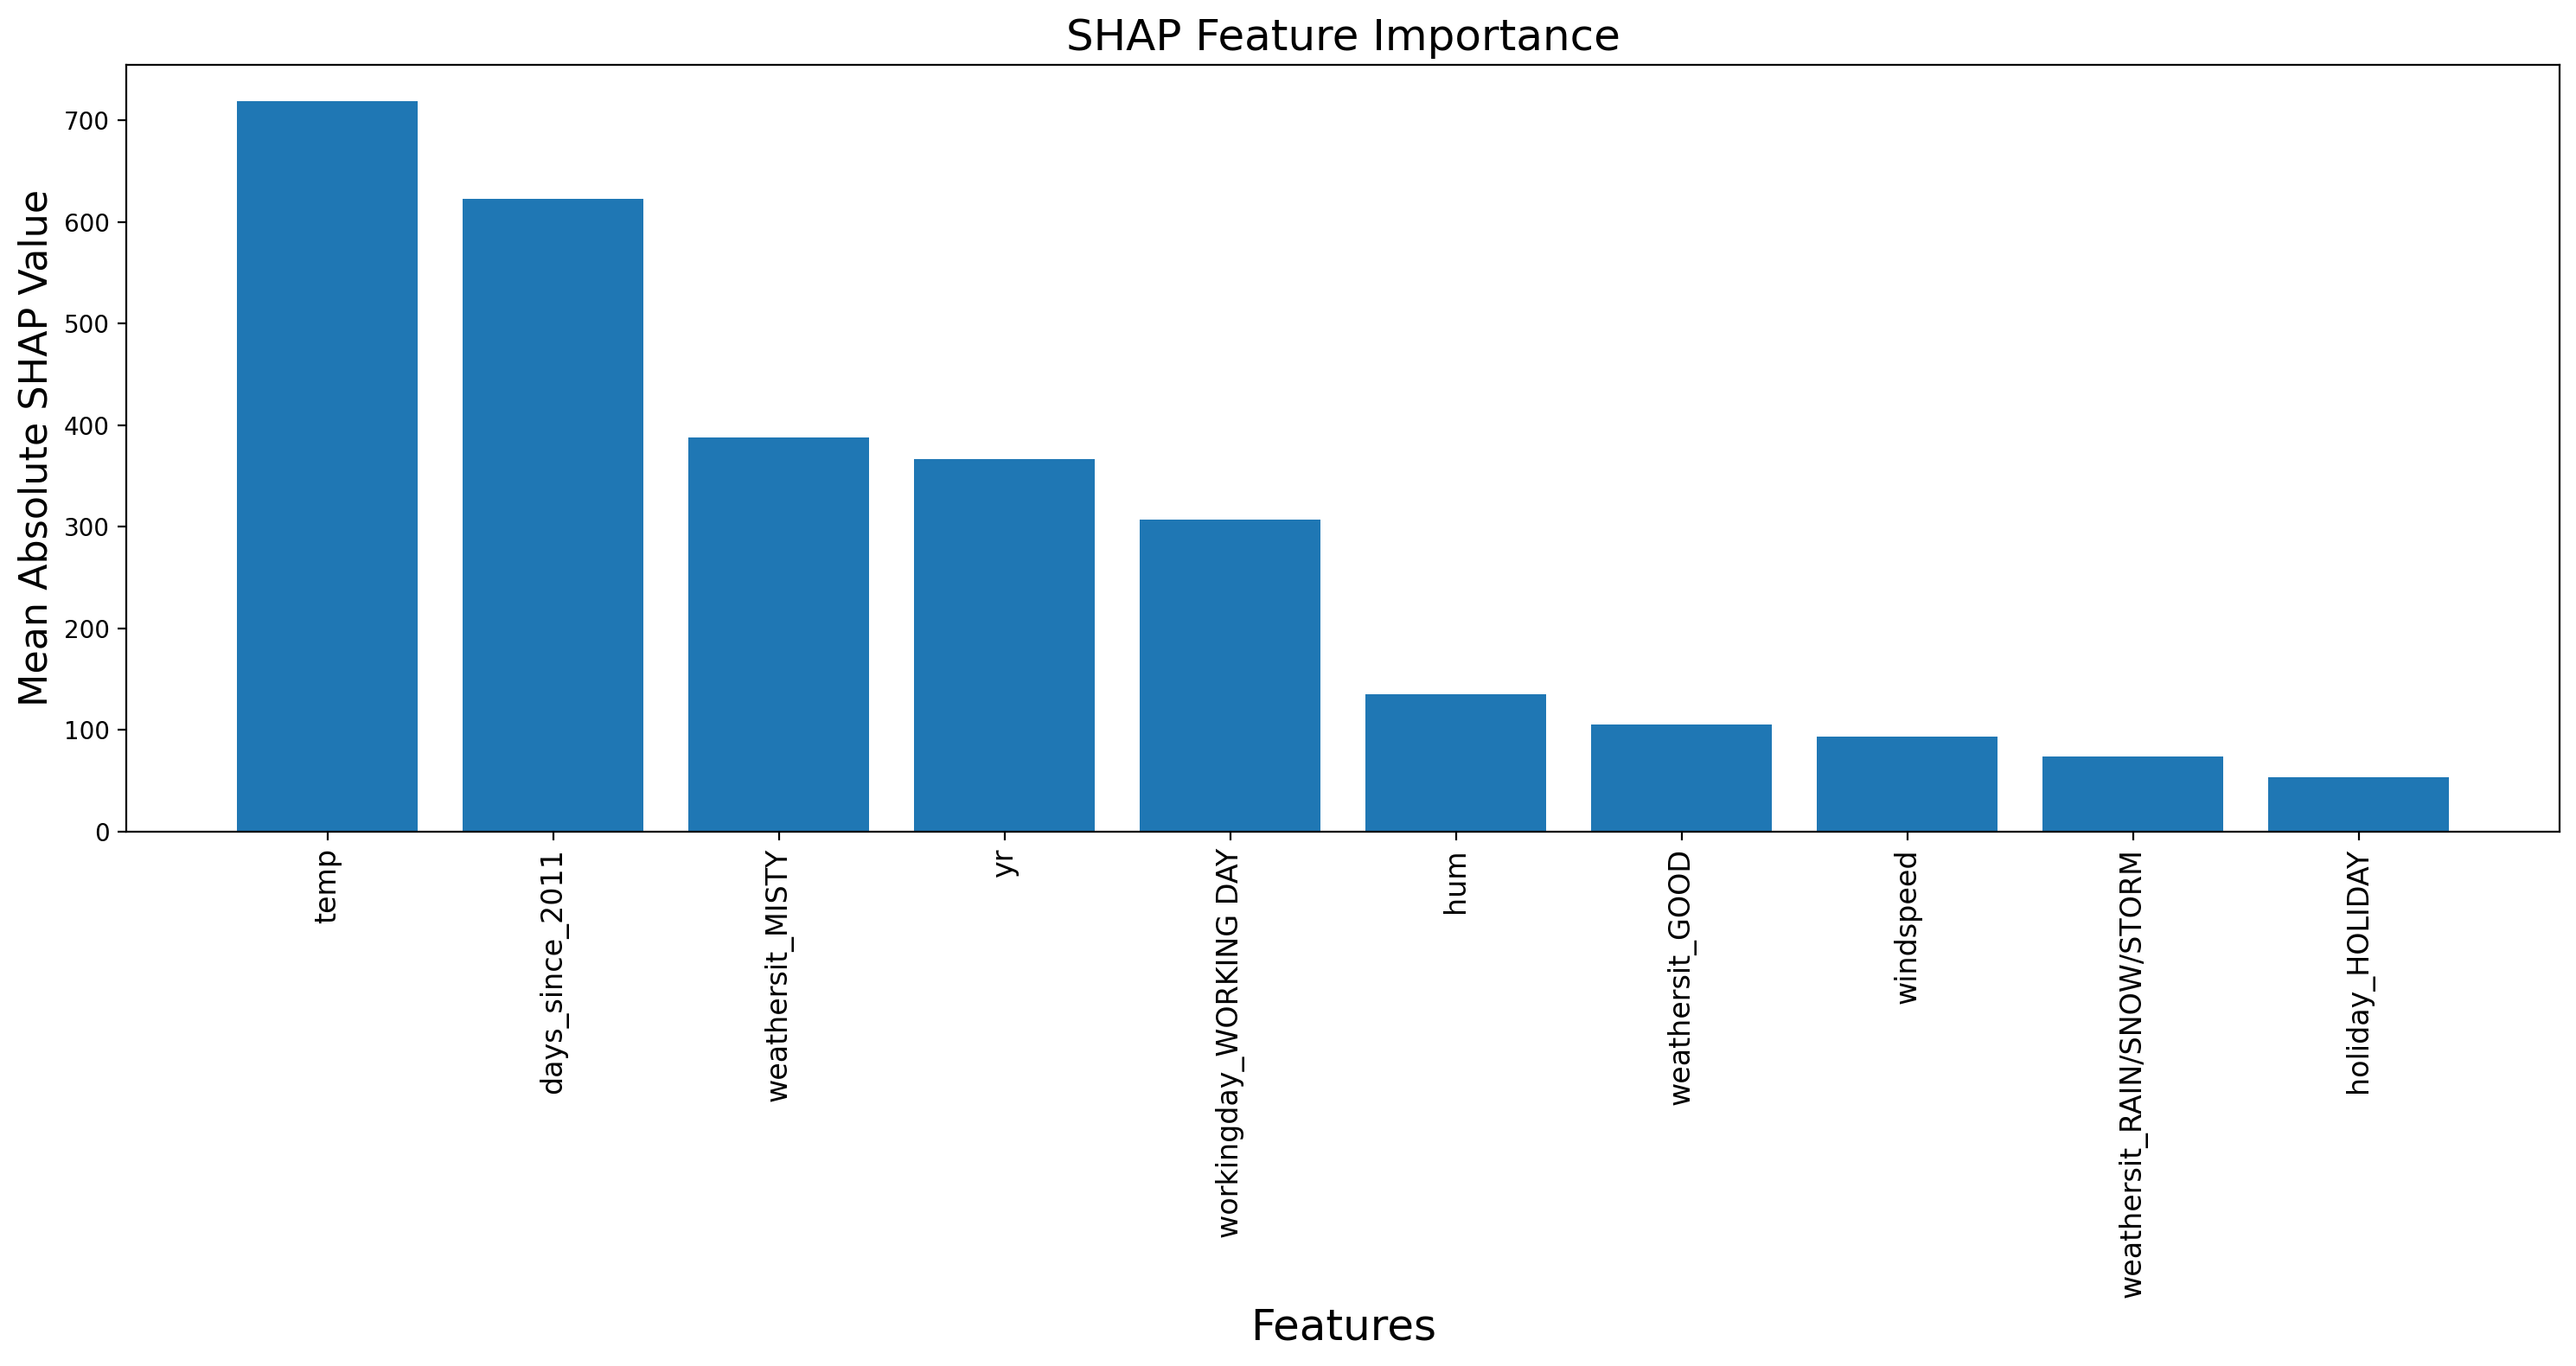

In [293]:
import torch
import numpy as np
from captum.attr import KernelShap
import matplotlib.pyplot as plt

# Instantiate KernelShap
sk = KernelShap(mod.forward)

# Prepare your dataset
# Here, let's assume X_train is your entire dataset
# And that it's a PyTorch Tensor

X_test_t = torch.from_numpy(X_test_scaled)  
# Attribute SHAP values
global_shap_values = []

r_g=5
for instance in X_test_t:
    global_cumulative_shap_values = 0
    for _ in range(r_g):
        shap_values = sk.attribute(instance.unsqueeze(0).float().to(device), baseline,n_samples=200)
        global_cumulative_shap_values+=shap_values
    global_mean_shap_values=global_cumulative_shap_values/r_g
    global_shap_values.append(global_mean_shap_values.detach().cpu().numpy())

global_shap_values = np.array(global_shap_values)
global_shap_values = global_shap_values.reshape(-1, global_shap_values.shape[-1])

# Compute the mean absolute SHAP values for each feature
feature_importance = np.mean(np.abs(global_shap_values), axis=0)

# Sort features by their importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = X_test_with_confounder.columns[sorted_indices]

# Plot the SHAP feature importance
plt.figure(figsize=(15, 8),dpi=200)
plt.bar(sorted_feature_names, sorted_feature_importance)
plt.title('SHAP Feature Importance',fontsize=18)
plt.xlabel('Features',fontsize=18)
plt.ylabel('Mean Absolute SHAP Value',fontsize=16)
plt.xticks(rotation=90,fontsize=12)
plt.tight_layout()
plt.show()


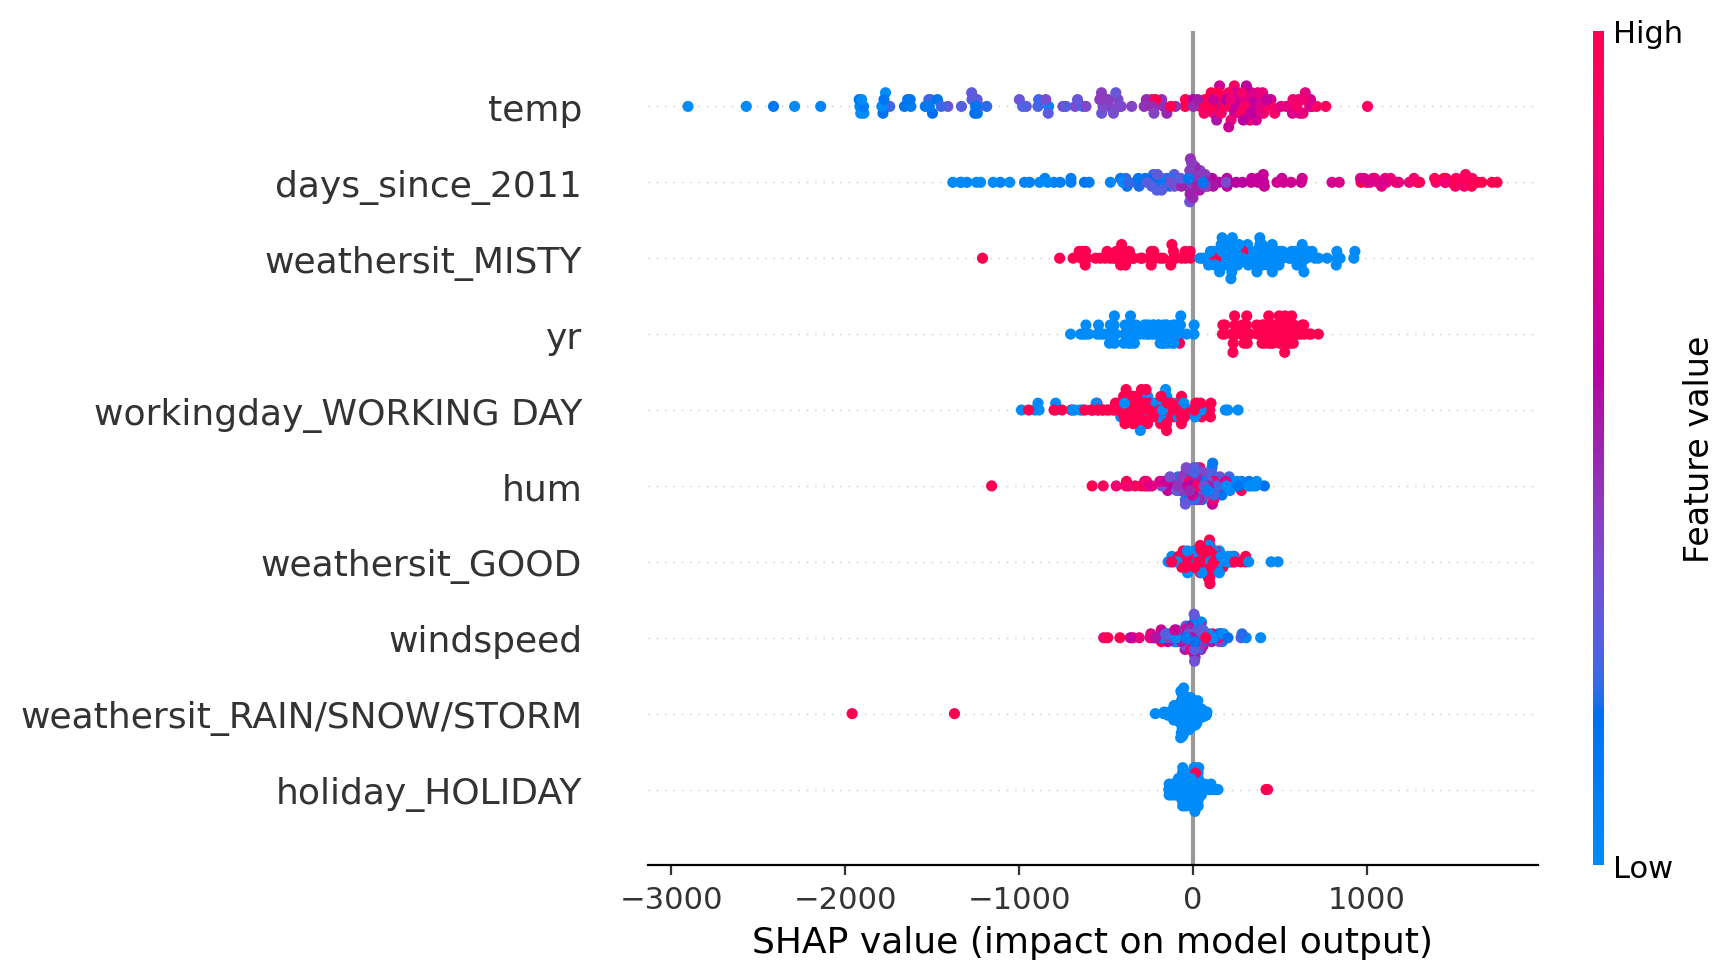

In [295]:
import shap

# Convert the global_shap_values back to a format that shap.summary_plot can understand
global_shap_values = global_shap_values.reshape(global_shap_values.shape[0], -1)

# Create a SHAP summary plot
shap.summary_plot(global_shap_values, X_test_scaled, feature_names=X_test_with_confounder.columns,plot_size=(9,5))
